# **Credit Card Fraud Detection**

*Les dades del dataset son de titulars europeus recollides durant 2 dies de setembre de 2013, amb un total de 492 fraus en 284,807 transaccions. El desbalaceig entre transaccions legítimes i fraudulentes és significatiu, amb un 0,172% de transaccions classificades com a fraus. Les característiques numèriques del conjunt de dades, derivades d'una transformació PCA, inclouen components principals (V1 a V28), mentre que 'Time' i 'Amount' no han estat subjectes a aquesta transformació.*

In [39]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import imblearn
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss, ClusterCentroids
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import *

In [40]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploratory Data Analysis

- Exploració de relació entre Time i frau tenint en compte la durada de la recopilació de dades
- Exploració de relació entre Amount i frau
- Analisis d'outlayers
- Clustering per determinar tipus de clients? o potser tipus de transacció?

In [41]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


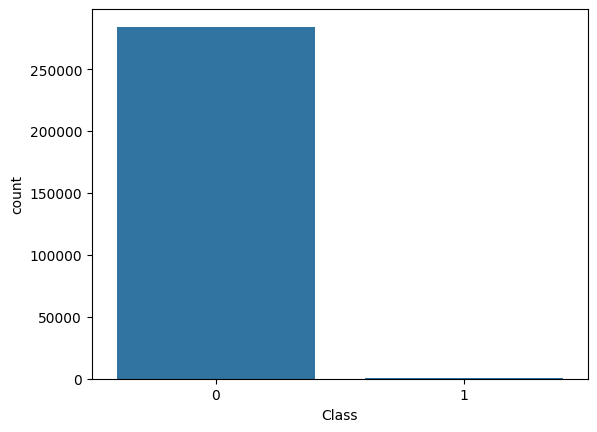

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [42]:
sns.countplot(x='Class', data=df)
plt.show()
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

In [43]:
print(f'Null values: {df.isnull().sum().sum()}')

Null values: 0


com veiem no hi ha nulls en el nostre dataset aixi que podem proseguir.

###  Analisis de Amount and Time.

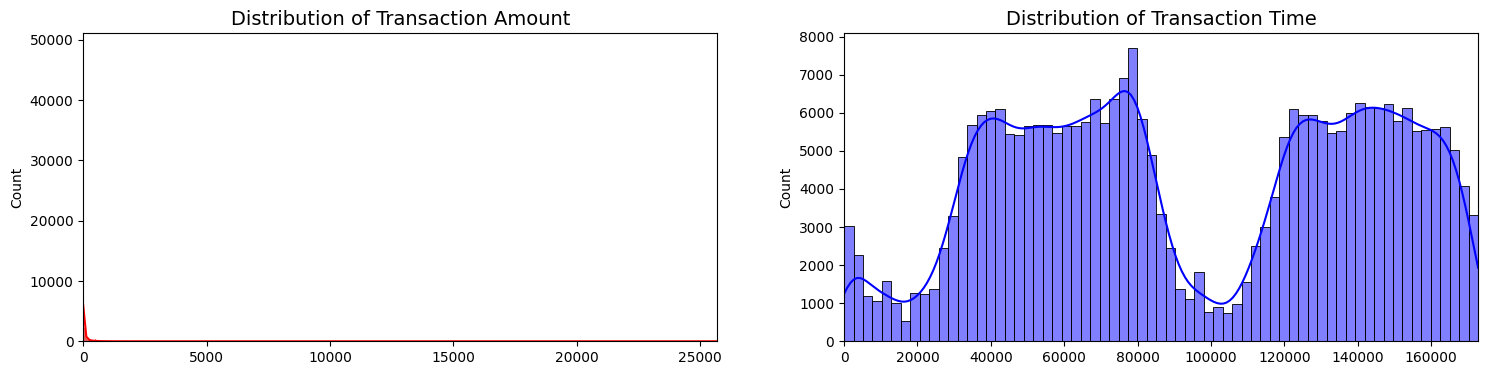

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

Com podem vere la majoria de transaccions van ser de menys de 100 euros. D'altra banda podem veure que el nombre de transaccions decreixen per la nit de 00:00h fins a les 08:00h aproximadament.

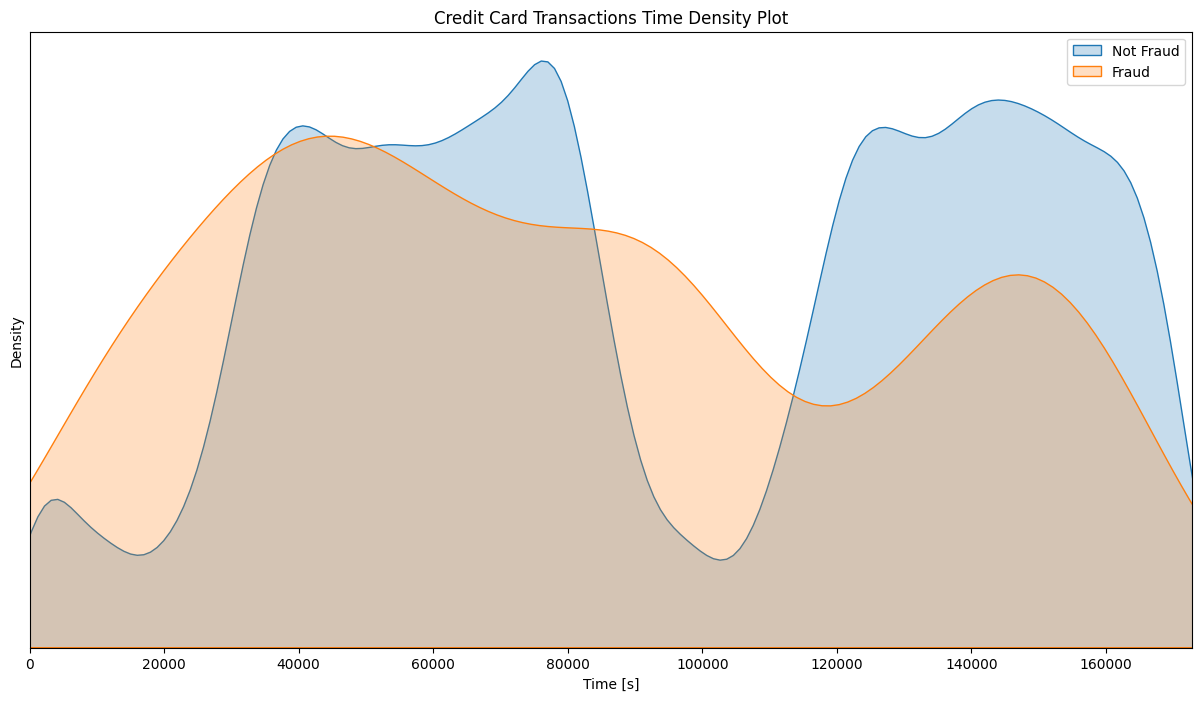

In [45]:
plt.figure(figsize=(15, 8))

class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

sns.kdeplot(class_0, label='Not Fraud', fill=True)
sns.kdeplot(class_1, label='Fraud', fill=True)

plt.title('Credit Card Transactions Time Density Plot')
plt.xlabel('Time [s]')
plt.ylabel('Density')

plt.legend()
plt.yticks([])
plt.xlim(0, max(df['Time']))

plt.show()


Es interesant destacar que el nombre de transaccions fraudulentes es mantenen de manera mes constant en comparacio a les transaccions validas.

Seguidament mirarem las diferents distribucions de Amount i Time basantnos en les diferents hores del dia.

In [46]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
data = pd.DataFrame(tmp)
data.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
data

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.00,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.00,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.00,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.00,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.00,4002.88,1555,106989.39,68.803466,17.900,45355.430437
...,...,...,...,...,...,...,...,...,...
89,45.0,1,12.31,39.98,2,52.29,26.145000,26.145,382.814450
90,46.0,0,0.00,25691.16,6458,449369.58,69.583397,15.000,132269.354973
91,46.0,1,0.00,634.30,6,1433.23,238.871667,194.490,67185.062017
92,47.0,0,0.00,10199.44,4852,333212.69,68.675328,14.000,56123.940988


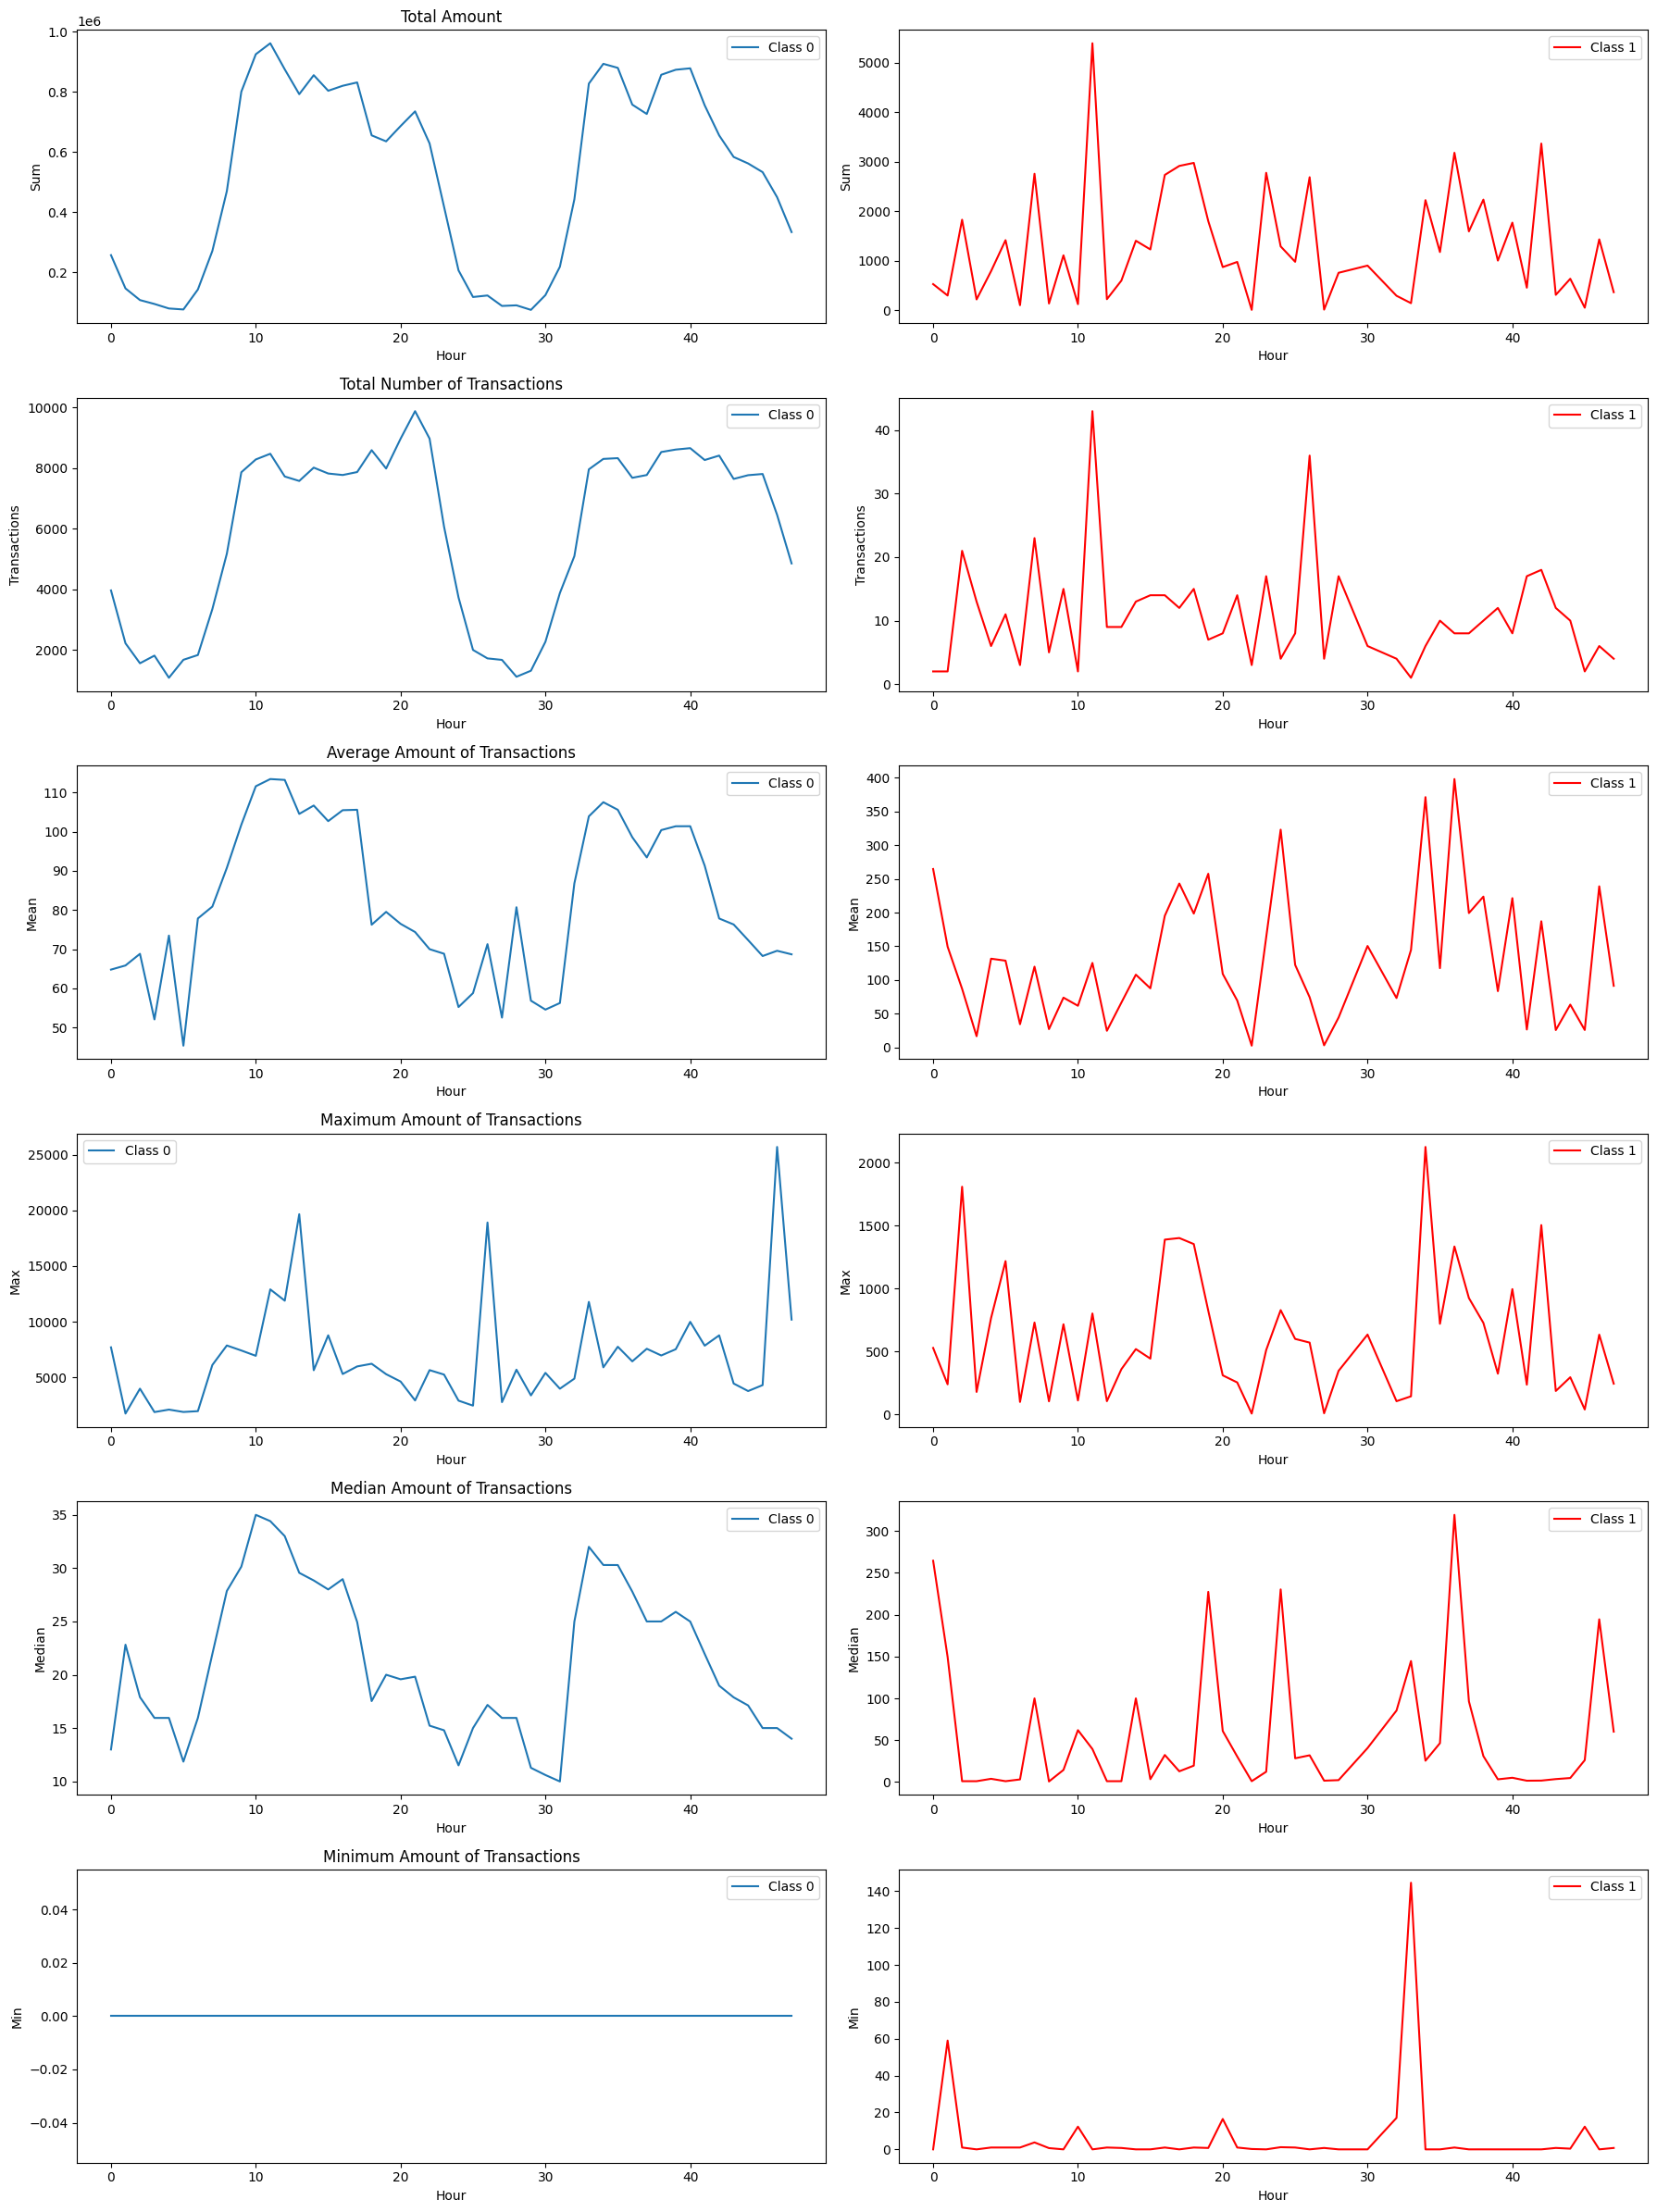

In [47]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(18, 24))

s1 = sns.lineplot(ax=axs[0, 0], x="Hour", y="Sum", data=data.loc[data.Class==0], label="Class 0")
s2 = sns.lineplot(ax=axs[0, 1], x="Hour", y="Sum", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[0, 0].set_title("Total Amount")

s3 = sns.lineplot(ax=axs[1, 0], x="Hour", y="Transactions", data=data.loc[data.Class==0], label="Class 0")
s4 = sns.lineplot(ax=axs[1, 1], x="Hour", y="Transactions", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[1, 0].set_title("Total Number of Transactions")

s5 = sns.lineplot(ax=axs[2, 0], x="Hour", y="Mean", data=data.loc[data.Class==0], label="Class 0")
s6 = sns.lineplot(ax=axs[2, 1], x="Hour", y="Mean", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[2, 0].set_title("Average Amount of Transactions")

s7 = sns.lineplot(ax=axs[3, 0], x="Hour", y="Max", data=data.loc[data.Class==0], label="Class 0")
s8 = sns.lineplot(ax=axs[3, 1], x="Hour", y="Max", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[3, 0].set_title("Maximum Amount of Transactions")

s9 = sns.lineplot(ax=axs[4, 0], x="Hour", y="Median", data=data.loc[data.Class==0], label="Class 0")
s10 = sns.lineplot(ax=axs[4, 1], x="Hour", y="Median", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[4, 0].set_title("Median Amount of Transactions")

s11 = sns.lineplot(ax=axs[5, 0], x="Hour", y="Min", data=data.loc[data.Class==0], label="Class 0")
s12 = sns.lineplot(ax=axs[5, 1], x="Hour", y="Min", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[5, 0].set_title("Minimum Amount of Transactions")

for ax in axs.flatten():
    ax.legend()

plt.tight_layout()
plt.show()

En general podem vere que mentres les transaccions valides seguient un patro horari vastat exacte les transaccions fraudulesntes seguien una distribucio mes sorollosa i cintinua. Aixo pot ser interesant per detectar transaccions fraudulentes en base l'horari.

### Analisis d'outliers

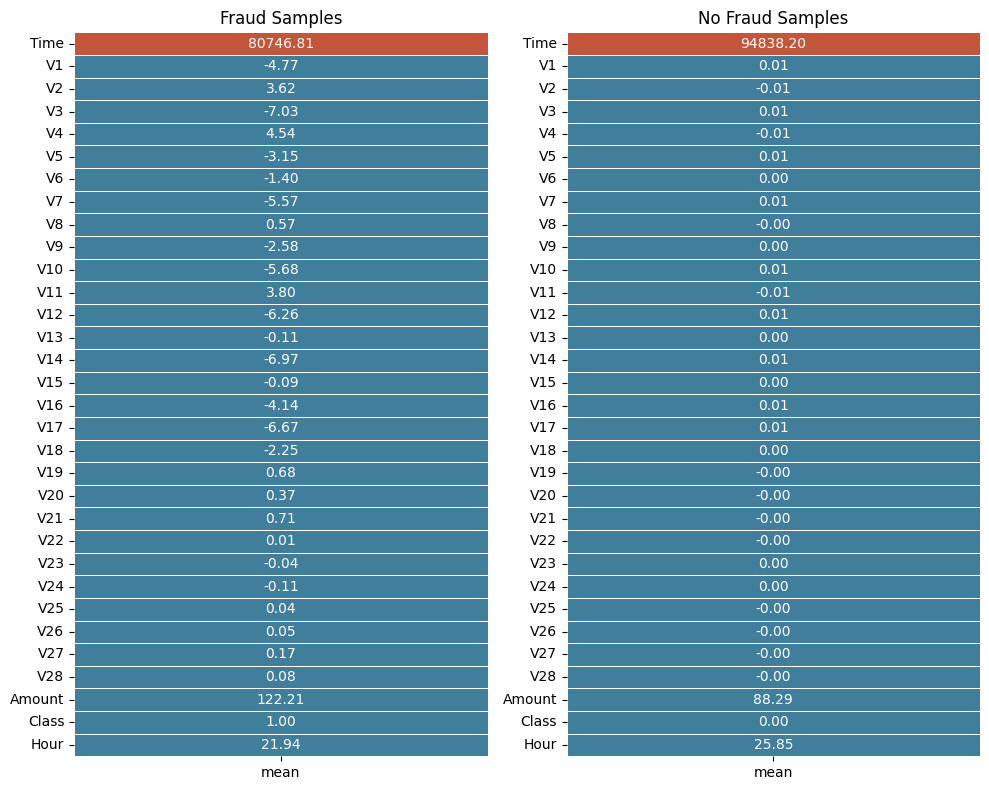

In [48]:
fraud = df[df['Class'] == 1].describe().T
nofraud = df[df['Class'] == 0].describe().T

cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (10,8))
plt.subplot(1,2,1)
sns.heatmap(fraud[['mean']][:],annot = True,cmap=cmap,linewidths=0.5, linecolor='white', cbar = False,fmt = '.2f')
plt.title('Fraud Samples');

plt.subplot(1,2,2)
sns.heatmap(nofraud[['mean']][:],annot = True,cmap=cmap, linewidths=0.5, linecolor='white', cbar = False,fmt = '.2f')
plt.title('No Fraud Samples');

fig.tight_layout()

Podem observar qur la majoria de transaccions no fraudulentes tenen una mitjana de aproximadament 0 per a totes les carcteristiques derivades del PCA metres que las de les fraudulentes son mes irregulars. A mes podem veure diferencies notables en la mitja de Amount i Hour (Time)

In [49]:
feature_names = df.columns.drop(['Time', 'Hour'])

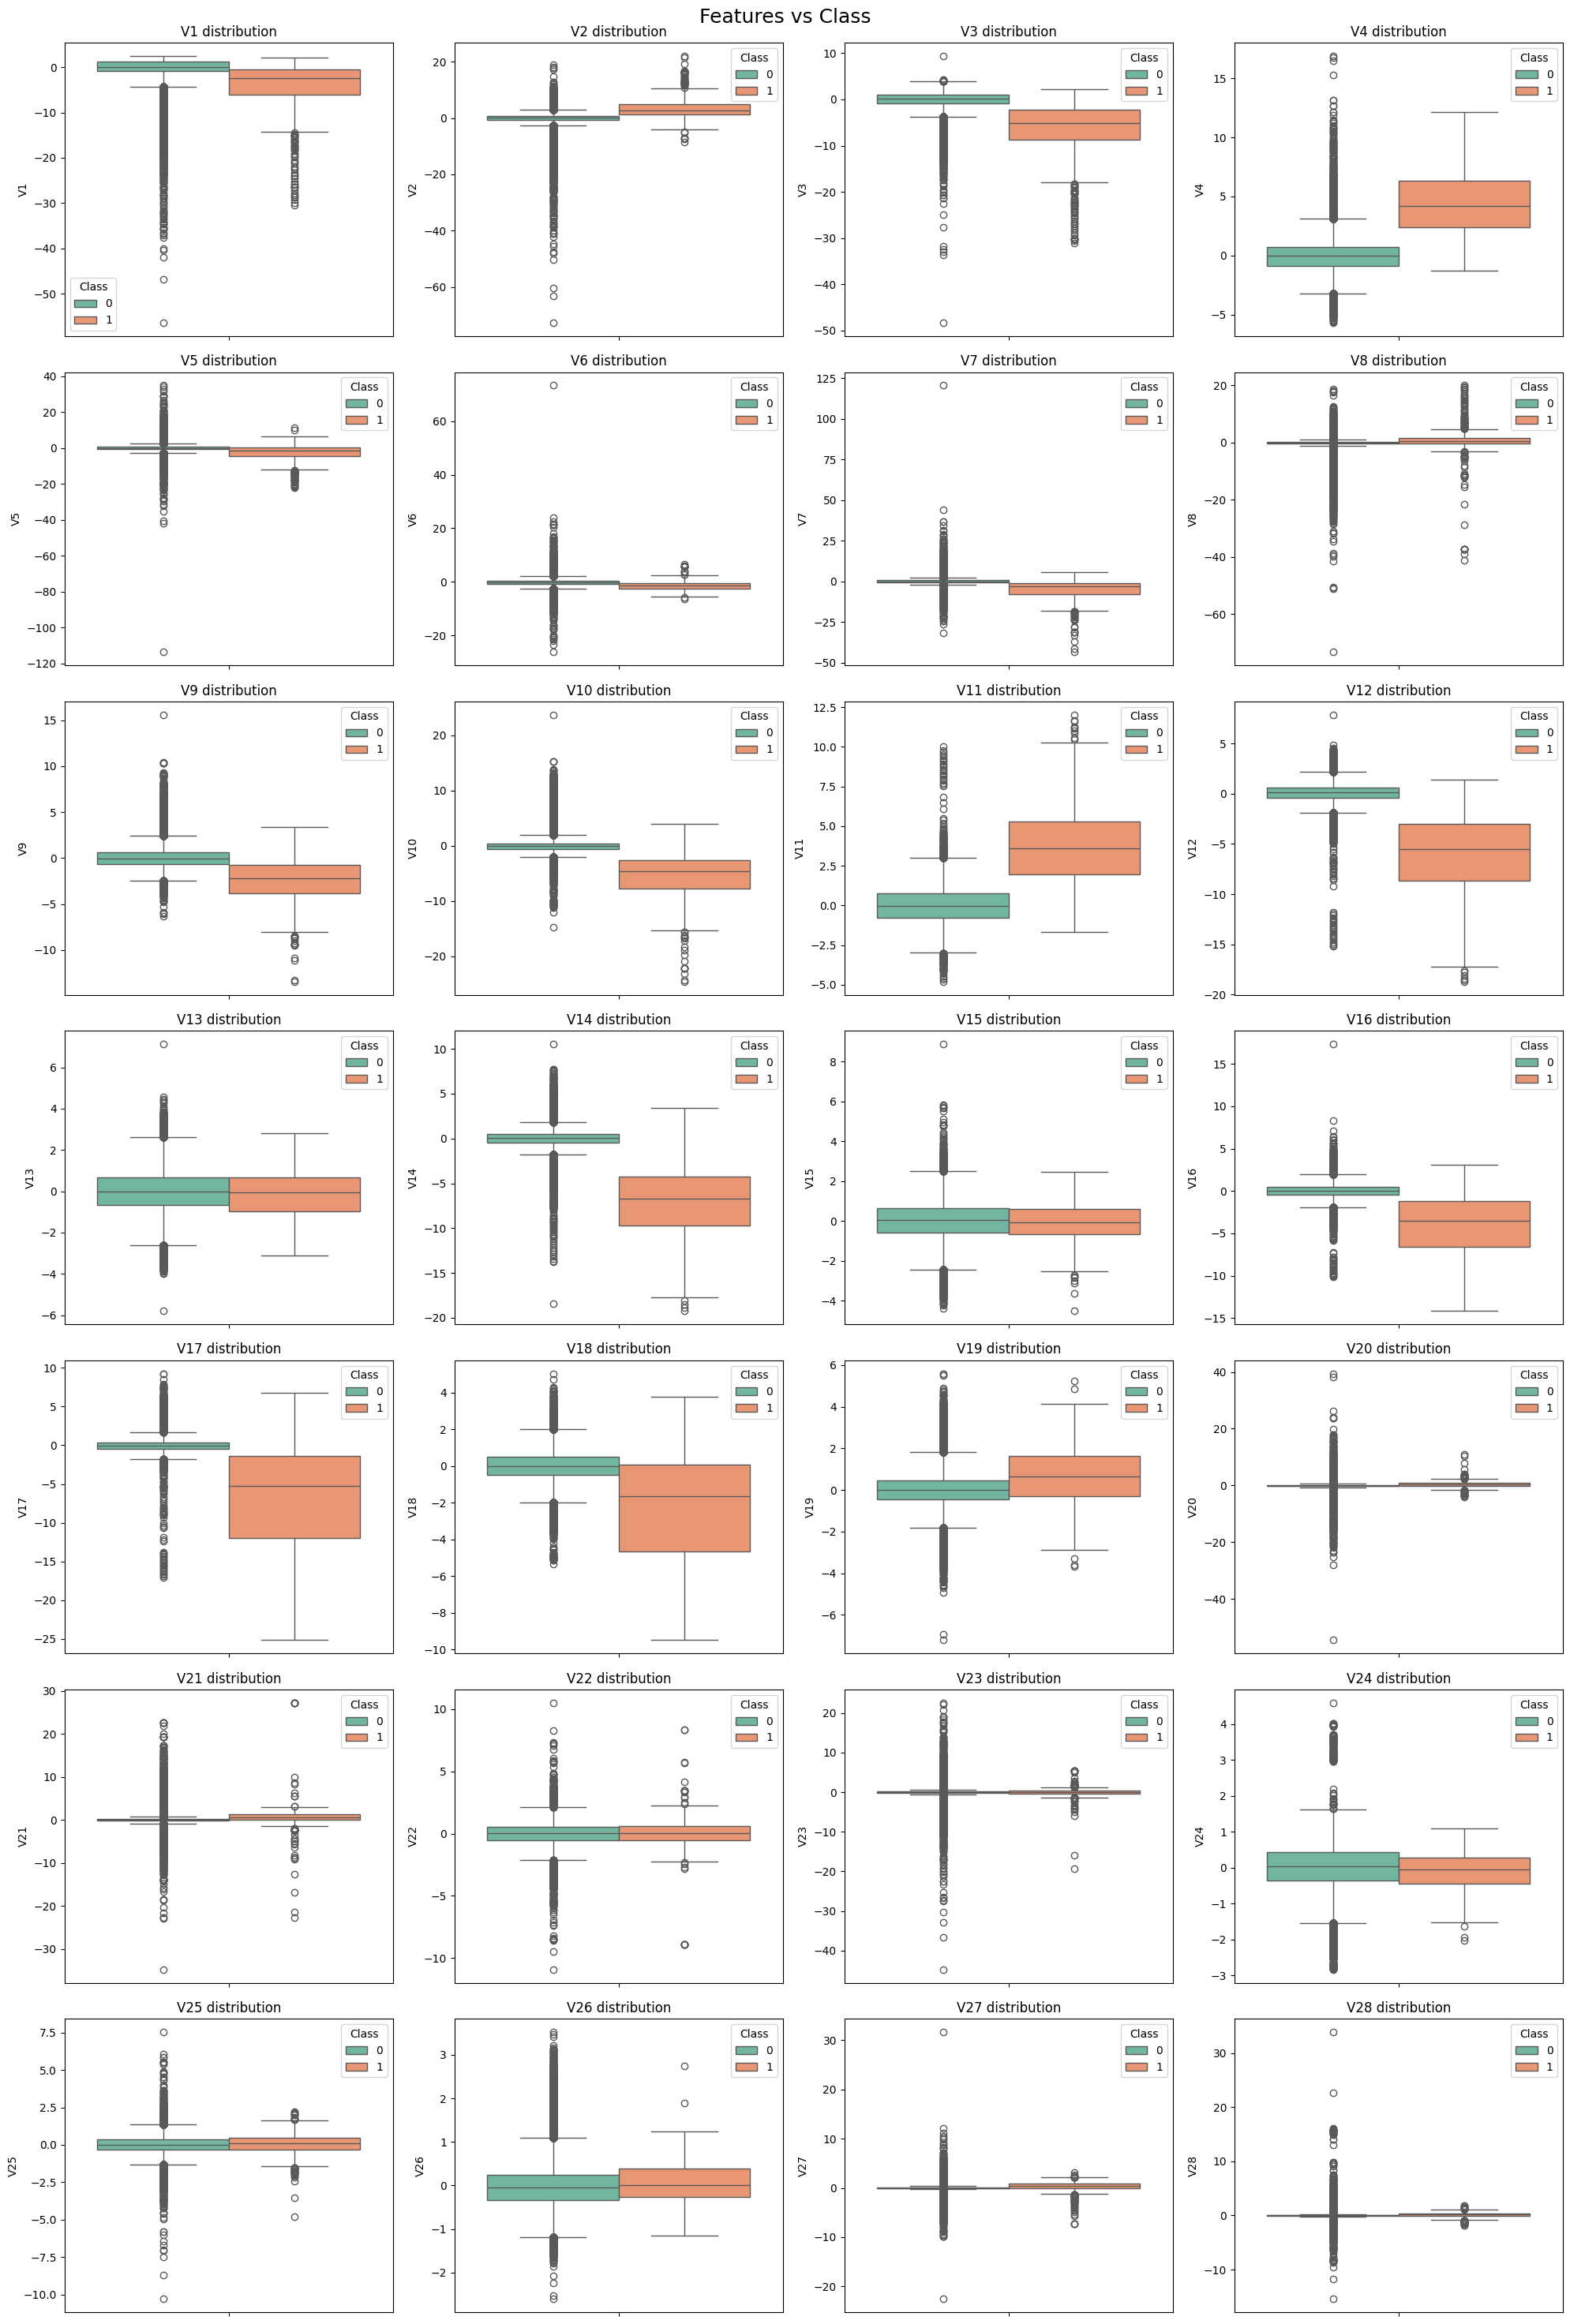

In [50]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 30))
fig.suptitle('Features vs Class\n', size=18)

for i, ax in zip(feature_names, axes.flatten()):
    sns.boxplot(ax=ax, data=df, hue='Class', y=i, palette="Set2")
    ax.set_title(i + ' distribution')

plt.tight_layout()


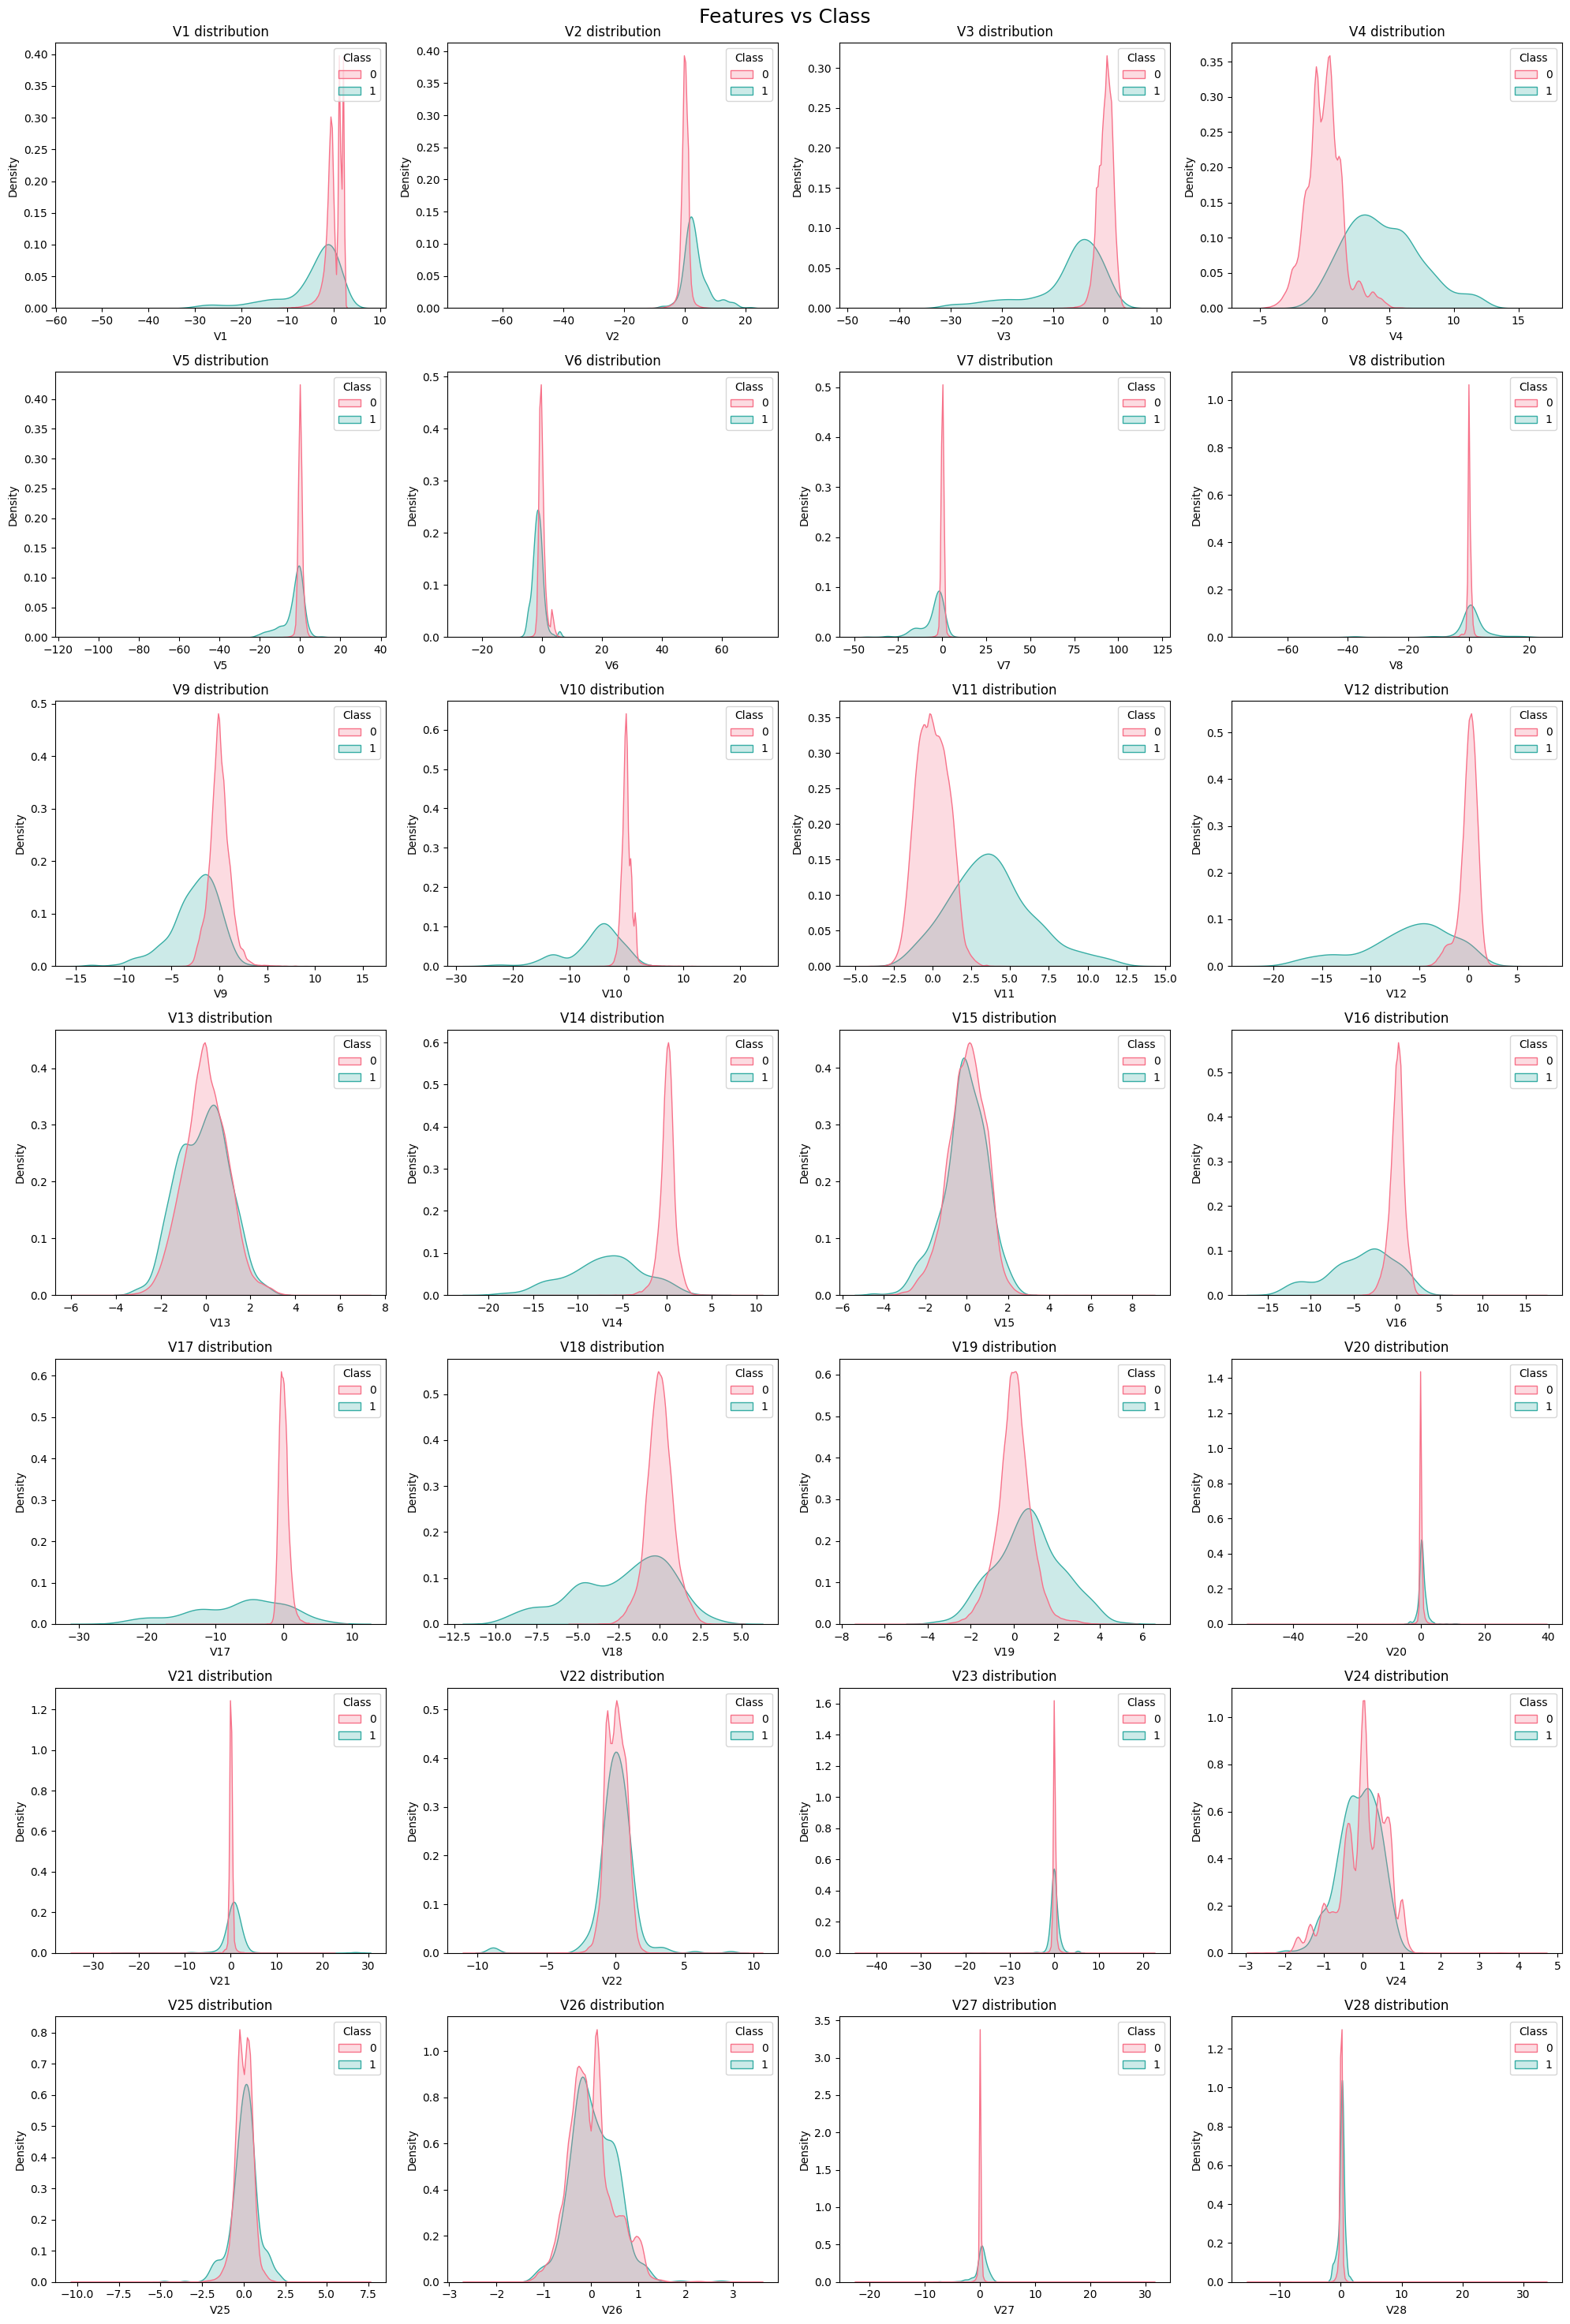

In [51]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 30))
fig.suptitle('Features vs Class\n', size=18)

for i, ax in zip(feature_names, axes.flatten()):
    sns.kdeplot(data=df, x=i, hue='Class', fill=True, common_norm=False, ax=ax, palette='husl')
    ax.set_title(i + ' distribution')

plt.tight_layout()
plt.show()

Com podem veure tenim molts outliers, en un primer moment podriem pensar que els hem d'eliminar per si ens fixem be podem veure que elinianriem a bona part de les mostres de la classe 1.

In [52]:
def IQR_method(df, n, features):
    outlier_list = []
    for column in features:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
        outlier_list.extend(outlier_list_column)
    
    outlier_list = Counter(outlier_list)
    multiple_outliers = list(k for k, v in outlier_list.items() if v > n)
    
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers is:', df1.shape[0] + df2.shape[0])
    
    return multiple_outliers

In [53]:
feature_list = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

Outliers_IQR = IQR_method(df,1,feature_list)
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)


Total number of outliers is: 31904


In [54]:
print ('The amount of frauds in df before dropping outliers: ', len(df[df['Class'] == 1]))
print ('The amount of frauds in df after dropping outliers: ', len(df_out[df_out['Class'] == 1]))

The amount of frauds in df before dropping outliers:  492
The amount of frauds in df after dropping outliers:  26


Com podem veure perdem moltes mostres de la classe 1 (Fraud), per aixo en aquest cas no eliminarem outliers.

### Correlation Analysis

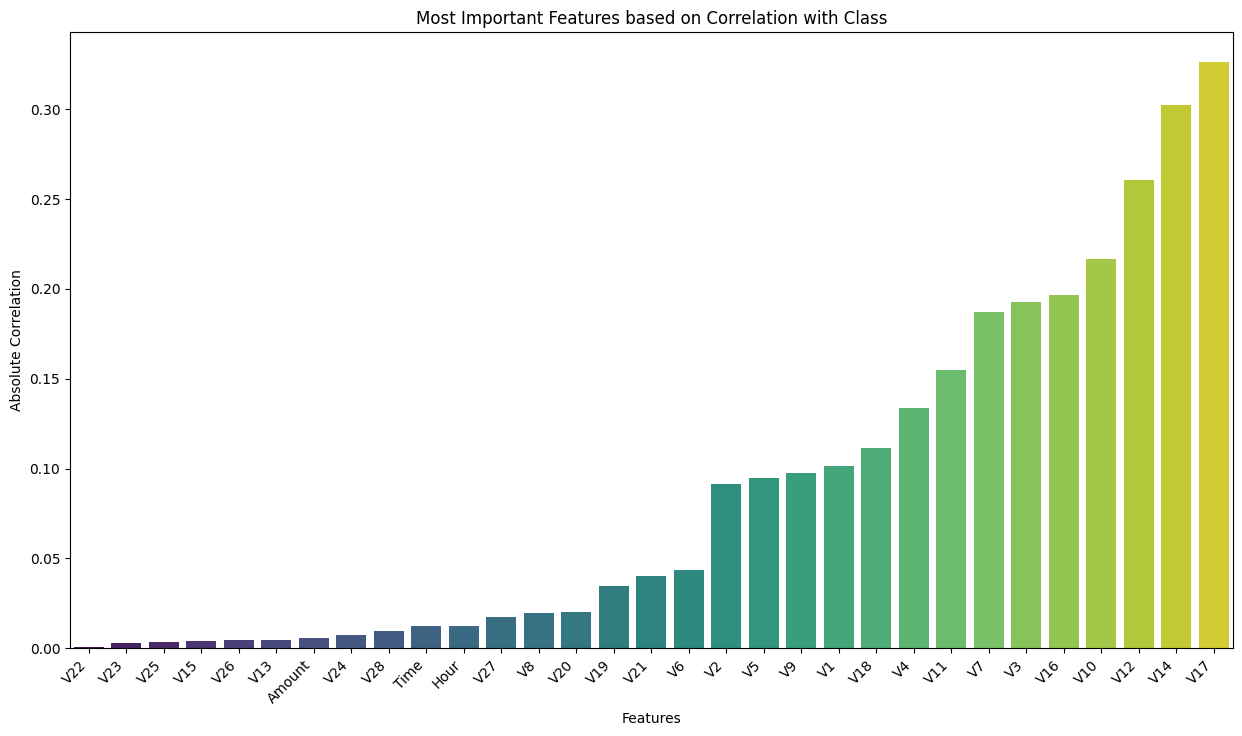

In [55]:
plt.figure(figsize=(15, 8))

correlation = df.corr()['Class'].abs().sort_values()
correlation = correlation[correlation.index != 'Class']

sns.barplot(x=correlation.index, y=correlation.values, hue=correlation.index,  palette='viridis')
plt.title('Most Important Features based on Correlation with Class')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')

plt.show()

<Figure size 1500x800 with 0 Axes>

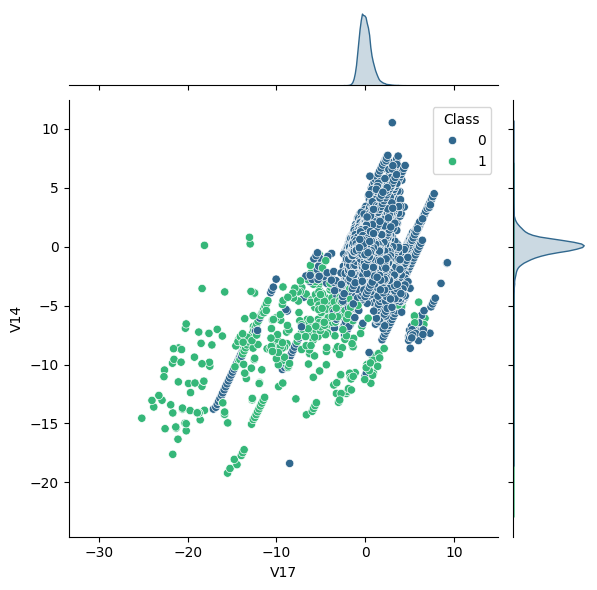

In [56]:
plt.figure(figsize=(15, 8))
sns.jointplot(x='V17', y='V14',hue='Class', data=df, palette ='viridis')
plt.show()

<Figure size 1500x800 with 0 Axes>

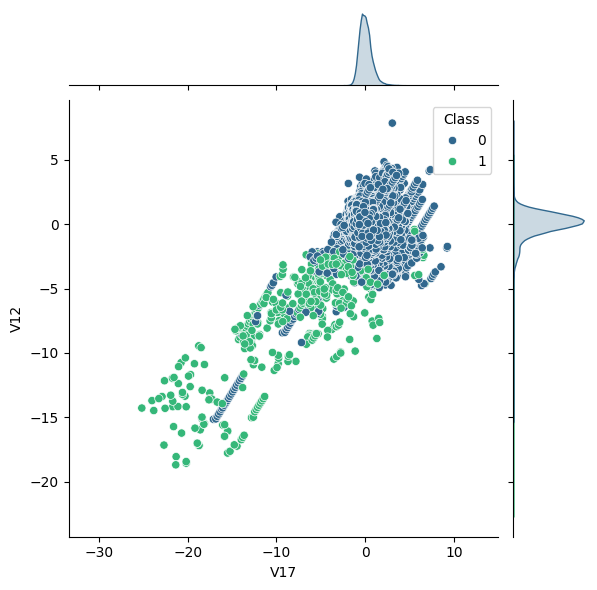

In [57]:
plt.figure(figsize=(15, 8))
sns.jointplot(x='V17', y='V12',hue='Class', data=df, palette ='viridis')
plt.show()

<Figure size 1500x800 with 0 Axes>

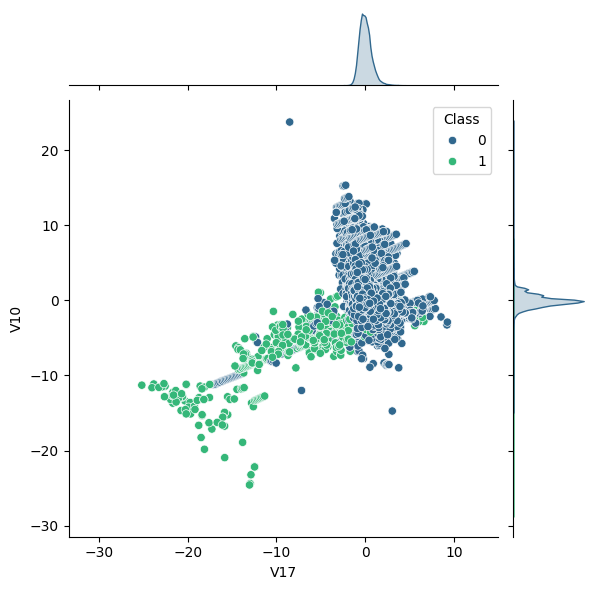

In [58]:
plt.figure(figsize=(15, 8))
sns.jointplot(x='V17', y='V10',hue='Class', data=df, palette ='viridis')
plt.show()

Com podem observar el nostre dataset te moltes features aixi que utilitzarem el Correlation Score per determinar el feature selecrion (-0.075, +0.075) tot i que per interpretavilitat deixarem els atributs Amount i Hour.

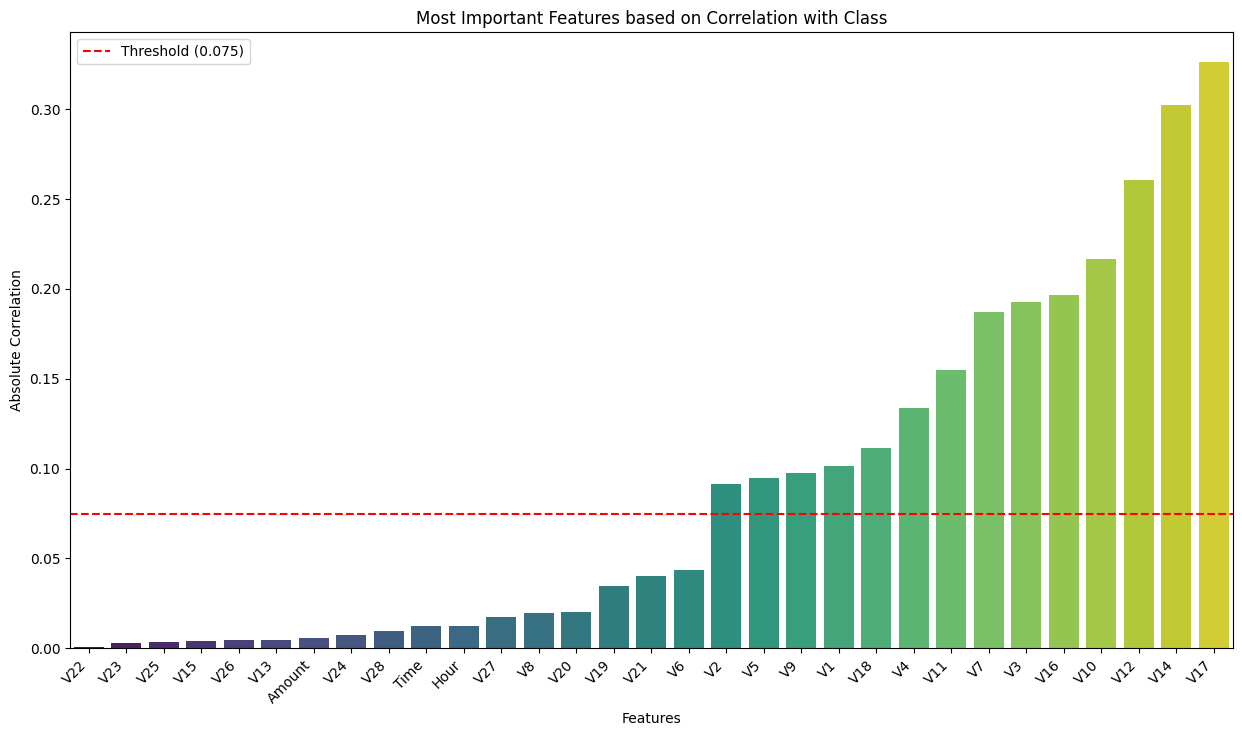

In [59]:
plt.figure(figsize=(15, 8))
correlation = df.corr()['Class'].abs().sort_values()
correlation = correlation[correlation.index != 'Class']
corr_threshold = 0.075
sns.barplot(x=correlation.index, y=correlation.values, hue=correlation.index, palette='viridis')
plt.title('Most Important Features based on Correlation with Class')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=corr_threshold, color='red', linestyle='--', label=f'Threshold ({corr_threshold})')
plt.legend()
plt.show()

In [60]:
corr_df = df[['V2','V5','V9','V1','V18','V4','V11','V7','V3', 'V16', 'V10', 'V12', 'V14', 'V17', 'Amount', 'Hour', 'Class']].copy(deep = True)
corr_df

,V2,V5,V9,V1,V18,V4,V11,V7,V3,V16,V10,V12,V14,V17,Amount,Hour,Class
0,-0.072781,-0.338321,0.363787,-1.359807,0.025791,1.378155,-0.551600,0.239599,2.536347,-0.470401,0.090794,-0.617801,-0.311169,0.207971,149.62,0.0,0
1,0.266151,0.060018,-0.255425,1.191857,-0.183361,0.448154,1.612727,-0.078803,0.166480,0.463917,-0.166974,1.065235,-0.143772,-0.114805,2.69,0.0,0
2,-1.340163,-0.503198,-1.514654,-1.358354,-0.121359,0.379780,0.624501,0.791461,1.773209,-2.890083,0.207643,0.066084,-0.165946,1.109969,378.66,0.0,0
3,-0.185226,-0.010309,-1.387024,-0.966272,1.965775,-0.863291,-0.226487,0.237609,1.792993,-1.059647,-0.054952,0.178228,-0.287924,-0.684093,123.50,0.0,0
4,0.877737,-0.407193,0.817739,-1.158233,-0.038195,0.403034,-0.822843,0.592941,1.548718,-0.451449,0.753074,0.538196,-1.119670,-0.237033,69.99,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,10.071785,-5.364473,1.914428,-11.881118,0.510632,-2.066656,-1.593105,-4.918215,-9.834783,1.107641,4.356170,2.711941,4.626942,1.991691,0.77,47.0,0
284803,-0.055080,0.868229,0.584800,-0.732789,-1.221179,-0.738589,-0.150189,0.024330,2.035030,-0.711757,-0.975926,0.915802,-0.675143,-0.025693,24.79,47.0,0
284804,-0.301254,2.630515,0.432454,1.919565,0.395652,-0.557828,0.411614,-0.296827,-3.249640,0.140716,-0.484782,0.063119,-0.510602,0.313502,67.88,47.0,0
284805,0.530483,-0.377961,0.392087,-0.240440,1.113981,0.689799,-1.933849,-0.686180,0.702510,-0.608577,-0.399126,-0.962886,0.449624,0.509928,10.00,47.0,0


## Balancig Dataset

<img src="imbalance.png" width="600">


In [61]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### **Data Preprocessing**

#### <u>Over-Sampling</u>


*SMOTE*

In [62]:
smote = SMOTE(n_jobs=5)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

*ADASYN*

In [63]:
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_jobs=5)
X_train_ADASYN, y_train_ADASYN = adasyn.fit_resample(X_train, y_train)

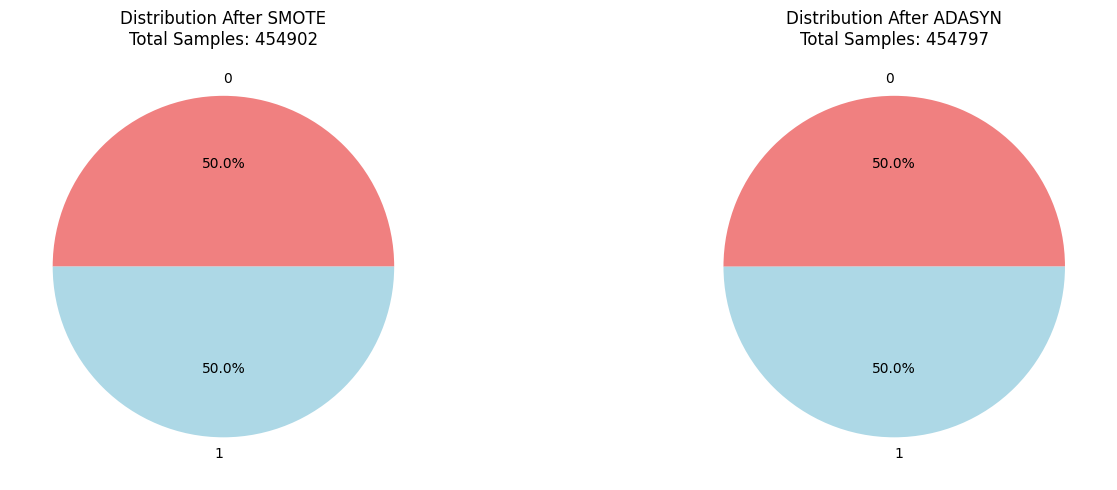

In [64]:
class_counts_after_smote = Counter(y_train_SMOTE)
class_counts_after_adasyn = Counter(y_train_ADASYN)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.pie(class_counts_after_smote.values(), labels=class_counts_after_smote.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Distribution After SMOTE\nTotal Samples: {}'.format(sum(class_counts_after_smote.values())))

plt.subplot(1, 2, 2)
plt.pie(class_counts_after_adasyn.values(), labels=class_counts_after_adasyn.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Distribution After ADASYN\nTotal Samples: {}'.format(sum(class_counts_after_adasyn.values())))

plt.tight_layout()
plt.show()

#### <u>Under-Sampling</u>

*NearMiss*

In [65]:
nm = NearMiss(version=3, n_jobs=5)
X_train_NM, y_train_NM= nm.fit_resample(X_train, y_train)

*ClusterCentroids*

In [66]:
cc = ClusterCentroids()
X_train_CC, y_train_CC = cc.fit_resample(X_train, y_train)

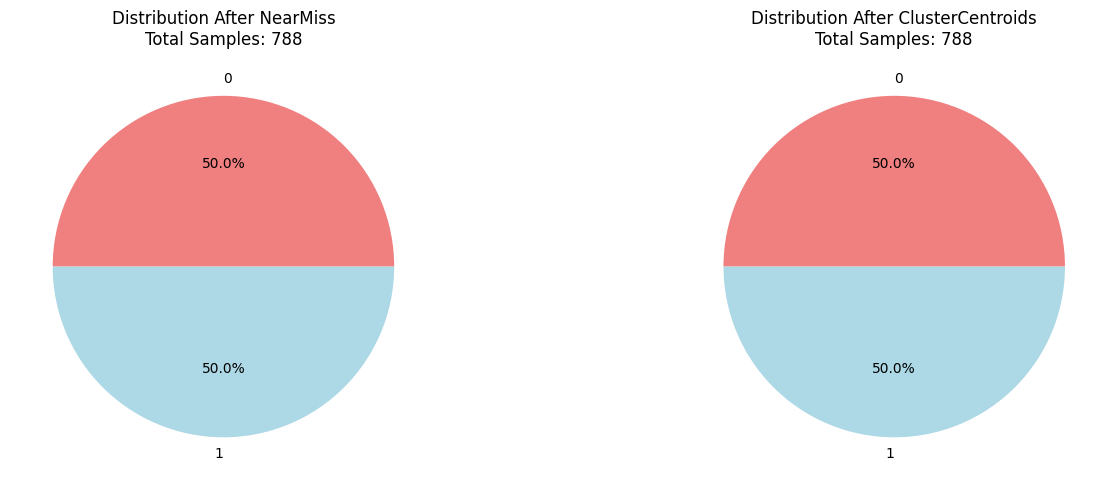

In [67]:
class_counts_after_nm = Counter(y_train_NM)
class_counts_after_cc = Counter(y_train_CC)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.pie(class_counts_after_nm.values(), labels=class_counts_after_nm.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Distribution After NearMiss\nTotal Samples: {}'.format(sum(class_counts_after_nm.values())))

plt.subplot(1, 2, 2)
plt.pie(class_counts_after_cc.values(), labels=class_counts_after_cc.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Distribution After ClusterCentroids\nTotal Samples: {}'.format(sum(class_counts_after_cc.values())))

plt.tight_layout()
plt.show()

#### <u>Over-Sampling and Under-Sampling Combined</u>

In [68]:
smoteenn = SMOTEENN(random_state=42, n_jobs=5)
X_train_SMOTEENN, y_train_SMOTEENN = smoteenn.fit_resample(X_train, y_train)

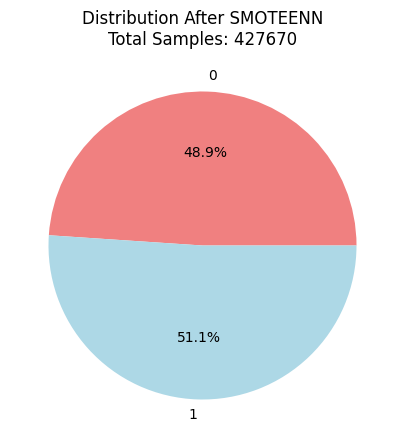

In [69]:
class_counts_after_SMOTEENN = Counter(y_train_SMOTEENN)

plt.figure(figsize=(15, 5))

plt.pie(class_counts_after_SMOTEENN.values(), labels=class_counts_after_SMOTEENN.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Distribution After SMOTEENN\nTotal Samples: {}'.format(sum(class_counts_after_SMOTEENN.values())))

plt.show()

### Feature Scaling

In [70]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_train_SMOTE = scaler.fit_transform(X_train_SMOTE)
X_train_ADASYN = scaler.fit_transform(X_train_ADASYN)

X_train_NM = scaler.fit_transform(X_train_NM)
X_train_CC = scaler.fit_transform(X_train_CC)

X_train_SMOTEENN = scaler.fit_transform(X_train_SMOTEENN)

## Model evaluation

In [71]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def model_cross_validation(model, X, y, cv=stratified_kfold, scoring='f1_macro'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return scores

def perform_grid_search(model, param_grid, X, y, cv, scoring = 'f1_macro', model_name = 'Model'):
    clf = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=scoring, verbose=3, n_jobs=-1)
    best_clf = clf.fit(X, y)
    print(model_name)
    print('Best Score: ' + str(best_clf.best_score_))
    print('Best Parameters: ' + str(best_clf.best_params_))
    return best_clf

def perform_randomized_search(model, param_distributions, X, y, cv, n_iter=100, scoring='f1_macro', model_name='Model'):
    random_search = RandomizedSearchCV(model, param_distributions=param_distributions, n_iter=n_iter, cv=cv, scoring=scoring, verbose=3, n_jobs=-1)
    best_model = random_search.fit(X, y)
    print(model_name)
    print('Best Score: ' + str(best_model.best_score_))
    print('Best Parameters: ' + str(best_model.best_params_))
    return best_model

def print_metrics_table(models, X, y, metrics=['accuracy', 'precision', 'recall', 'f1_macro'], cv=stratified_kfold):
    # metrics_data = []

    # for model in models:
    #     scores = []
    #     model_scores = cross_val_score(model, X, y, cv=cv, scoring=metrics)
    #     scores.extend(model_scores.mean(axis=0))
    #     metrics_data.append(scores)
    #     print('done')
    # metrics_df = pd.DataFrame(metrics_data, columns=metrics, index=[model.__class__.__name__ for model in models])
    # display(metrics_df) 
    
    f1macro_data = []

    for model in models:
        scoring_function = make_scorer(f1_score, average='macro')
        f1macro_score = cross_val_score(model, X, y, cv=cv, scoring=scoring_function).mean()
        f1macro_data.append(f1macro_score)

    f1macro_df = pd.DataFrame(f1macro_data, columns=['f1_macro'], index=[model.__class__.__name__ for model in models])
    display(f1macro_df) 
    return f1macro_df

def plot_pr_curve_for_models(models, X, y):
    plt.figure(figsize=(10, 6))
    cv = stratified_kfold

    for model in models:
        predictions = cross_val_predict(model, X, y, cv=cv, method='predict_proba', n_jobs=-1)
        precision, recall, _ = precision_recall_curve(y, predictions[:, 1])
        auc_score = auc(recall, precision) 

        plt.plot(recall, precision, label=f'{model.__class__.__name__} (AUC: {auc_score:.4f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Different Models')
    plt.legend()
    plt.grid()
    plt.show()

In [72]:
svc = SVC(probability=True)
lr = LogisticRegression(max_iter=2000)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=1)
xgb = XGBClassifier(random_state=1)
voting_clf = VotingClassifier(estimators=[('lr', lr), ('knn', knn), ('rf', rf), ('svc', svc), ('xgb', xgb)], voting='soft')
models = [lr, knn, rf, xgb]

,f1_macro
LogisticRegression,0.917090
KNeighborsClassifier,0.905646
RandomForestClassifier,0.930032
XGBClassifier,0.935201


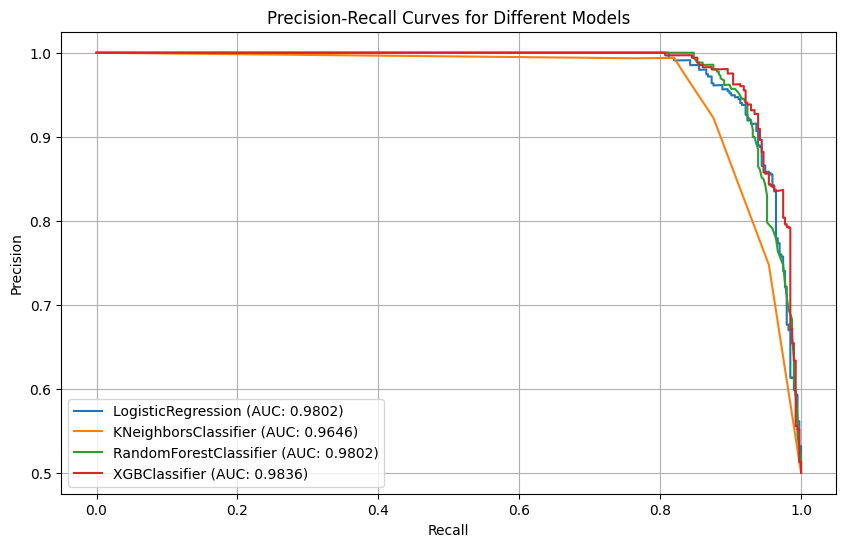

In [73]:
print_metrics_table(models, X_train_NM, y_train_NM)
plot_pr_curve_for_models(models, X_train_NM, y_train_NM)


,f1_macro
LogisticRegression,0.919553
KNeighborsClassifier,0.929819
RandomForestClassifier,0.997465
XGBClassifier,0.983507


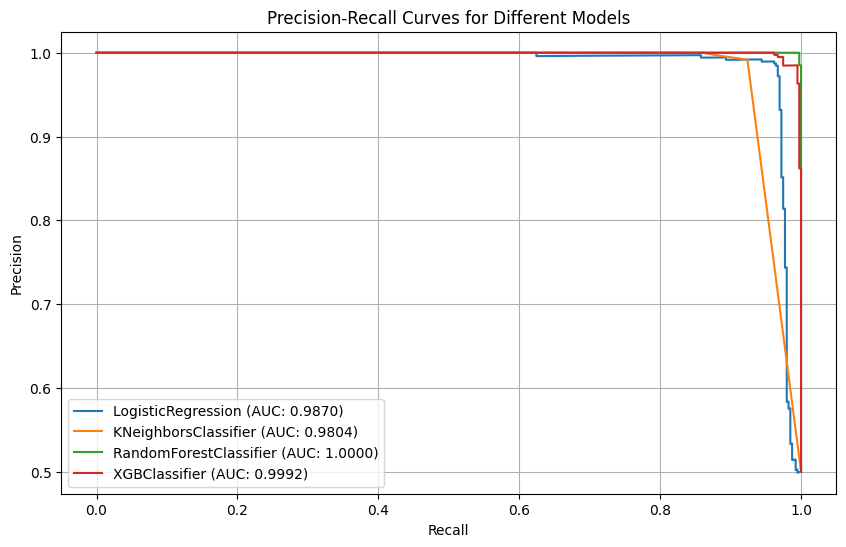

In [74]:
print_metrics_table(models, X_train_CC, y_train_CC)
plot_pr_curve_for_models(models, X_train_CC, y_train_CC)

,f1_macro
LogisticRegression,0.975504
KNeighborsClassifier,0.999270
RandomForestClassifier,0.999877
XGBClassifier,0.999811


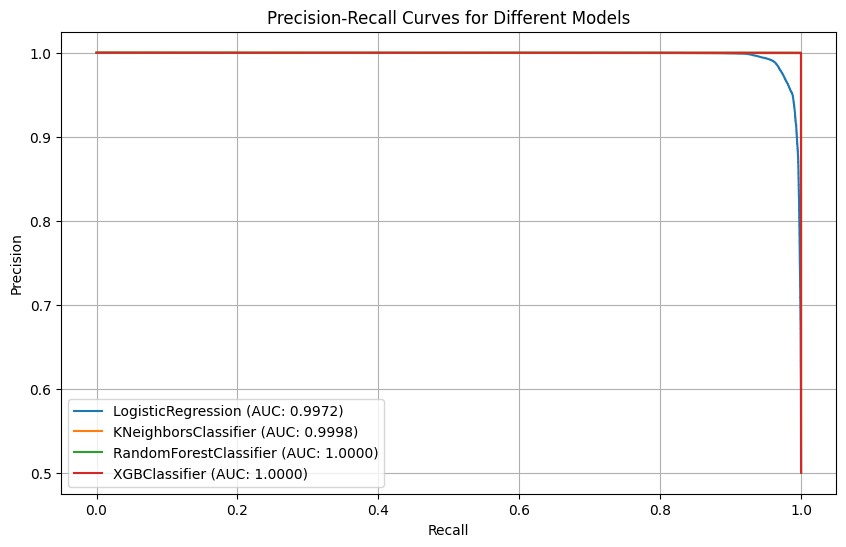

In [77]:
print_metrics_table(models, X_train_SMOTE, y_train_SMOTE)
plot_pr_curve_for_models(models, X_train_SMOTE, y_train_SMOTE)

,f1_macro
LogisticRegression,0.974378
KNeighborsClassifier,0.999272
RandomForestClassifier,0.999886
XGBClassifier,0.999826


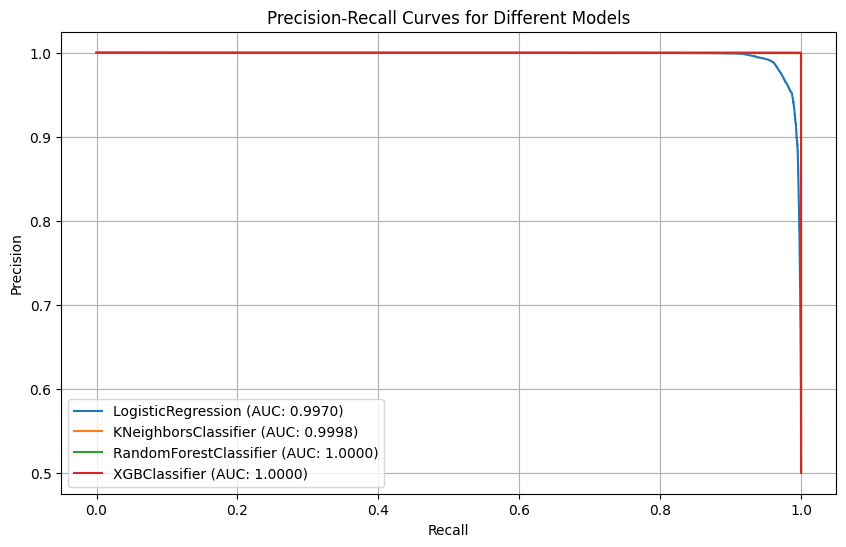

In [78]:
print_metrics_table(models, X_train_ADASYN, y_train_ADASYN)
plot_pr_curve_for_models(models, X_train_ADASYN, y_train_ADASYN)

In [80]:
print_metrics_table(models, X_train_SMOTEENN, y_train_SMOTEENN)
plot_pr_curve_for_models(models, X_train_SMOTEENN, y_train_SMOTEENN)

,f1_macro
LogisticRegression,0.977250
KNeighborsClassifier,0.999244
RandomForestClassifier,0.999895
XGBClassifier,0.999843
